# TinyMS CycleGAN Tutorial

In this tutorial, using TinyMS API to train/serve a CycleGAN model will be demonstrated. 

## Prerequisite
 - Ubuntu: `18.04`
 - Python: `3.7.x`
 - Flask: `1.1.2`
 - MindSpore: `CPU-1.1.1`
 - TinyMS: `0.1.0`
 - numpy: `1.17.5`
 - Pillow: `8.1.0`
 - pip: `21.0.1`
 - requests: `2.18.4`
 - matplotlib: `3.3.4`
 
## Introduction

TinyMS is a high-level API which is designed for amateur of deep learning. It minimizes the number of actions of users required to construct, train, evaluate and serve a model. TinyMS also provides tutorials and documentations for developers. 

This tutorial consists of five parts, `downloading dataset`, `training`, `define servable json`, `starting server` and `making predictions` in which the server will be run in a sub process. 

In [1]:
import os
import argparse
import json
import tinyms as ts
import numpy as np
import matplotlib.pyplot as plt

from PIL import Image
from tinyms import context, Tensor
from tinyms.serving import start_server, predict, list_servables, shutdown, server_started
from tinyms.data import GeneratorDataset, UnalignedDataset, GanImageFolderDataset, DistributedSampler
from tinyms.vision import cyclegan_transform
from tinyms.model.cycle_gan.cycle_gan import get_generator_discriminator, cycle_gan, TrainOneStepG, TrainOneStepD
from tinyms.losses import DiscriminatorLoss, GeneratorLoss
from tinyms.optimizers import Adam
from tinyms.data.utils import save_image, generate_image_list
from tinyms.utils.common_utils import GanReporter, gan_load_ckpt, GanImagePool
from tinyms.utils.train import cyclegan_lr
from tinyms.utils.eval import CityScapes, fast_hist, get_scores

[WARNING] ME(25552:140556571072320,MainProcess):2021-03-21-15:01:26.554.568 [mindspore/ops/operations/array_ops.py:2302] WARN_DEPRECATED: The usage of Pack is deprecated. Please use Stack.


### 1. Download dataset

In this tutorial, the [cityscapes](https://www.cityscapes-dataset.com/) dataset is used and processed. Click the link before proceeding to the official website to submit and download the dataset.

### 2. Train the model & evaluation
Define parameters and training process
```
Notice: Training on CPU is time consuming, we recommend skip training and using provided ckpt files to run. 
```

In [ ]:
def parse_args():
    parser = argparse.ArgumentParser(description='MindSpore Cycle GAN Example')
    parser.add_argument('--device_target', type=str, default="CPU", choices=['Ascend', 'GPU', 'CPU'],
                        help='device where the code will be implemented (default: CPU)')
    parser.add_argument('--dataset_path', type=str, default="/root/dataset/cityscapes", help='cityscape dataset path.')
    parser.add_argument('--phase', type=str, default="train", help='train, eval or predict.')
    parser.add_argument('--model', type=str, default="resnet", choices=("resnet", "unet"),
                        help='generator model, should be in [resnet, unet].')
    parser.add_argument('--max_epoch', type=int, default=200, help='epoch size for training, default is 200.')
    parser.add_argument('--n_epoch', type=int, default=100,
                        help='number of epochs with the initial learning rate, default is 100')
    parser.add_argument('--batch_size', type=int, default=1, help='Batch size.')
    parser.add_argument("--save_checkpoint_epochs", type=int, default=10,
                        help="Save checkpoint epochs, default is 10.")
    parser.add_argument("--G_A_ckpt", type=str, default="/etc/tinyms/serving/cyclegan_cityscape/G_A.ckpt", help="pretrained checkpoint file path of G_A.")
    parser.add_argument("--G_B_ckpt", type=str, default="/etc/tinyms/serving/cyclegan_cityscape/G_B.ckpt", help="pretrained checkpoint file path of G_B.")
    parser.add_argument("--D_A_ckpt", type=str, default=None, help="pretrained checkpoint file path of D_A.")
    parser.add_argument("--D_B_ckpt", type=str, default=None, help="pretrained checkpoint file path of D_B.")
    parser.add_argument('--outputs_dir', type=str, default='/root/',
                        help='models are saved here, default is ./outputs.')
    parser.add_argument('--save_imgs', type=bool, default=True,
                        help='whether save imgs when epoch end, default is True.')
    parser.add_argument("--cityscapes_dir", type=str, default="/root/dataset/cityscapes/testA", help="Path to the original cityscapes dataset")
    parser.add_argument("--result_dir", type=str, default="/root/dataset/cityscapes/testB", help="Path to the generated images to be evaluated")
    args_opt = parser.parse_args(args=[])
    return args_opt


args_opt = parse_args()

context.set_context(mode=context.GRAPH_MODE, device_target="CPU")

dataset_path = args_opt.dataset_path
phase = args_opt.phase
G_A_ckpt = args_opt.G_A_ckpt
G_B_ckpt = args_opt.G_B_ckpt
repeat_size = 1


model = args_opt.model
batch_size = args_opt.batch_size
max_dataset_size = float("inf")
outputs_dir = args_opt.outputs_dir

max_epoch = args_opt.max_epoch
n_epoch = args_opt.n_epoch
n_epoch = min(max_epoch, n_epoch)


def create_dataset(dataset_path, batch_size=1, repeat_size=1, max_dataset_size=None,
                   shuffle=True, num_parallel_workers=1, phase='train', data_dir='testA'):
    """ create Mnist dataset for train or eval.
    Args:
        data_path: Data path
        batch_size: The number of data records in each group
        repeat_size: The number of replicated data records
        num_parallel_workers: The number of parallel workers
    """
    # define dataset and apply the transform func
    if phase == 'train':
        ds = UnalignedDataset(dataset_path, phase, max_dataset_size=max_dataset_size, shuffle=True)

        device_num = 1
        distributed_sampler = DistributedSampler(len(ds), num_replicas=device_num, rank=0, shuffle=shuffle)
        gan_generator_ds = GeneratorDataset(ds, column_names=["image_A", "image_B"], sampler=distributed_sampler,
                                            num_parallel_workers=num_parallel_workers)
    else:
        datadir = os.path.join(dataset_path, data_dir)
        ds = GanImageFolderDataset(datadir, max_dataset_size=max_dataset_size)
        gan_generator_ds = GeneratorDataset(ds, column_names=["image", "image_name"],
                                            num_parallel_workers=num_parallel_workers)

    gan_generator_ds = cyclegan_transform.apply_ds(gan_generator_ds,
                                                   repeat_size=repeat_size,
                                                   batch_size=batch_size,
                                                   num_parallel_workers=num_parallel_workers,
                                                   shuffle=shuffle,
                                                   phase=phase)
    dataset_size = len(ds)
    return gan_generator_ds, dataset_size


# create dataset
dataset, args_opt.dataset_size = create_dataset(dataset_path, batch_size=batch_size, repeat_size=1,
                                                max_dataset_size=max_dataset_size, shuffle=True,
                                                num_parallel_workers=1, 
                                                phase="train", 
                                                data_dir=None)


G_A, G_B, D_A, D_B = get_generator_discriminator(model)
gan_load_ckpt(args_opt.G_A_ckpt, args_opt.G_B_ckpt, args_opt.D_A_ckpt, args_opt.D_B_ckpt,
              G_A, G_B, D_A, D_B)
generator_net = cycle_gan(G_A, G_B)

# define loss function and optimizer
loss_D = DiscriminatorLoss(D_A, D_B)
loss_G = GeneratorLoss(generator_net, D_A, D_B)
lr = cyclegan_lr(max_epoch, n_epoch, args_opt.dataset_size)

optimizer_G = Adam(generator_net.trainable_params(),
                   cyclegan_lr(max_epoch, n_epoch, args_opt.dataset_size), beta1=0.5)
optimizer_D = Adam(loss_D.trainable_params(),
                   cyclegan_lr(max_epoch, n_epoch, args_opt.dataset_size), beta1=0.5)

# build two net: generator net and descrinator net
net_G = TrainOneStepG(loss_G, generator_net, optimizer_G)
net_D = TrainOneStepD(loss_D, optimizer_D)

# train process
imgae_pool_A = GanImagePool(pool_size=50)
imgae_pool_B = GanImagePool(pool_size=50)


def train_process(args_opt, data_loader, net_G, net_D, imgae_pool_A, imgae_pool_B):
    reporter = GanReporter(args_opt)
    reporter.info('==========start training===============')
    for _ in range(max_epoch):
        reporter.epoch_start()
        for data in data_loader:
            img_A = data["image_A"]
            img_B = data["image_B"]
            res_G = net_G(img_A, img_B)
            fake_A = res_G[0]
            fake_B = res_G[1]
            res_D = net_D(img_A, img_B, imgae_pool_A.query(fake_A), imgae_pool_B.query(fake_B))
            reporter.step_end(res_G, res_D)
            reporter.visualizer(img_A, img_B, fake_A, fake_B)
        reporter.epoch_end(net_G)

    reporter.info('==========end training===============')

    
data_loader = dataset.create_dict_iterator()
train_process(args_opt, data_loader, net_G, net_D, imgae_pool_A, imgae_pool_B)

# eval
# original image dir
cityscapes_dir = args_opt.cityscapes_dir

# fake image dir generated after predict
result_dir = args_opt.result_dir


def eval_process(args_opt, cityscapes_dir, result_dir):
    CS = CityScapes()
    hist_perframe = ts.zeros((CS.class_num, CS.class_num)).asnumpy()
    cityscapes = generate_image_list(cityscapes_dir)
    args_opt.dataset_size = len(cityscapes)
    reporter = GanReporter(args_opt)
    reporter.start_eval()
    for i, img_path in enumerate(cityscapes):
        if i % 100 == 0:
            reporter.info('Evaluating: %d/%d' % (i, len(cityscapes)))
        img_name = os.path.split(img_path)[1]
        ids1 = CS.get_id(os.path.join(cityscapes_dir, img_name))
        ids2 = CS.get_id(os.path.join(result_dir, img_name))
        hist_perframe += fast_hist(ids1.flatten(), ids2.flatten(), CS.class_num)

    mean_pixel_acc, mean_class_acc, mean_class_iou, per_class_acc, per_class_iou = get_scores(hist_perframe)
    reporter.info("mean_pixel_acc:{}, mean_class_acc:{}, mean_class_iou: {}".format(mean_pixel_acc,
                                                                                    mean_class_acc,
                                                                                    mean_class_iou))
    reporter.info("************ Per class numbers below ************")
    for i, cl in enumerate(CS.classes):
        while len(cl) < 15:
            cl = cl + ' '
        reporter.info("{}: acc = {}, iou = {}".format(cl, per_class_acc[i], per_class_iou[i]))
    reporter.end_eval()

    
# Compare the similarity between the original image and the fake image
eval_process(args_opt, cityscapes_dir, result_dir)

```
Notice: If skipped training process, download the pretrained ckpt file and continue to serving
```
Click [G_A](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cityscapes/G_A.ckpt) to download G_A.ckpt file and [G_B](https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cityscapes/G_B.ckpt) to download G_B.ckpt file. Save them to `/etc/tinyms/serving/cyclegan_cityscape/`

Or run the following code to download and store the ckpt files:

In [2]:
ckpt_folder = '/etc/tinyms/serving/cyclegan_cityscape'
G_A_ckpt_path = '/etc/tinyms/serving/cyclegan_cityscape/G_A.ckpt'
G_B_ckpt_path = '/etc/tinyms/serving/cyclegan_cityscape/G_B.ckpt'

if not os.path.exists(ckpt_folder):
    !mkdir -p  /etc/tinyms/serving/cyclegan_cityscape
    !wget -P /etc/tinyms/serving/cyclegan_cityscape https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cityscapes/G_A.ckpt
    !wget -P /etc/tinyms/serving/cyclegan_cityscape https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cityscapes/G_B.ckpt
else:
    print('ckpt folder already exists')
    if not os.path.exists(G_A_ckpt_path):
        !wget -P /etc/tinyms/serving/cyclegan_cityscape https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cityscapes/G_A.ckpt
    if not os.path.exists(G_B_ckpt_path):
        !wget -P /etc/tinyms/serving/cyclegan_cityscape https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cityscapes/G_B.ckpt

ckpt folder already exists
--2021-03-21 15:01:30--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cityscapes/G_A.ckpt
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)... 49.4.112.113, 121.36.121.44, 49.4.112.5, ...
Connecting to ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.myhuaweicloud.com)|49.4.112.113|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 7785480 (7.4M) [binary/octet-stream]
Saving to: ‘/etc/tinyms/serving/cyclegan_cityscape/G_A.ckpt’

G_A.ckpt            100%[===================>]   7.42M  3.58MB/s    in 2.1s    

2021-03-21 15:01:33 (3.58 MB/s) - ‘/etc/tinyms/serving/cyclegan_cityscape/G_A.ckpt’ saved [7785480/7785480]

--2021-03-21 15:01:34--  https://ascend-tutorials.obs.cn-north-4.myhuaweicloud.com/ckpt_files/cityscapes/G_B.ckpt
Resolving ascend-tutorials.obs.cn-north-4.myhuaweicloud.com (ascend-tutorials.obs.cn-north-4.

### 3. Define servable.json

Define the servable json file for model name, format and number of classes for later use.

In [3]:
servable_json = [{'name': 'cyclegan_cityscape', 
                  'description': 'This servable hosts a Cycle GAN model predicting for cityscape dataset', 
                  'model': {
                      "name": "cycle_gan", 
                      "format": "ckpt", 
                      "g_model": "resnet"}}]
os.chdir("/etc/tinyms/serving")
json_data = json.dumps(servable_json, indent=4)

with open('servable.json', 'w') as json_file:
    json_file.write(json_data)

### 4. Start server

#### 4.1 Introduction
TinyMS Serving is a C/S(client/server) structure. There is a server and client. TinyMS using [Flask](https://flask.palletsprojects.com/en/1.1.x/) which is a micro web framework written in python as the C/S communication tool. In order to serve a model, user must start server first. If successfully started, the server will be run in a subprocess and listening to POST requests from 127.0.0.1 port 5000 sent by client and handle the requests using MindSpore backend which will construct the model, run the prediction and send the result back to the client.  

#### 4.2 start server
Run the following code block to start the server:

In [4]:
start_server()

Server starts at host 127.0.0.1, port 5000


### 5. Make predictions
####  5.1 List servables

Now, we can use `list_servables` function to check what model is servable right now.

In [5]:
list_servables()

[{'description': 'This servable hosts a Cycle GAN model predicting for cityscape dataset',
  'model': {'format': 'ckpt', 'g_model': 'resnet', 'name': 'cycle_gan'},
  'name': 'cyclegan_cityscape'}]

If the output `description` shows it is a `CycleGAN` model, then we can continue to next step to send our request.

#### 5.2 Sending request and get the result

Run `predict` function to send the request, in this tutorial, both `gray to color` and `color to gray` will be demonstrated. Recommend using pics from `cityscapes/test` to run the predict. If user using own pics, resize to `256*256`.

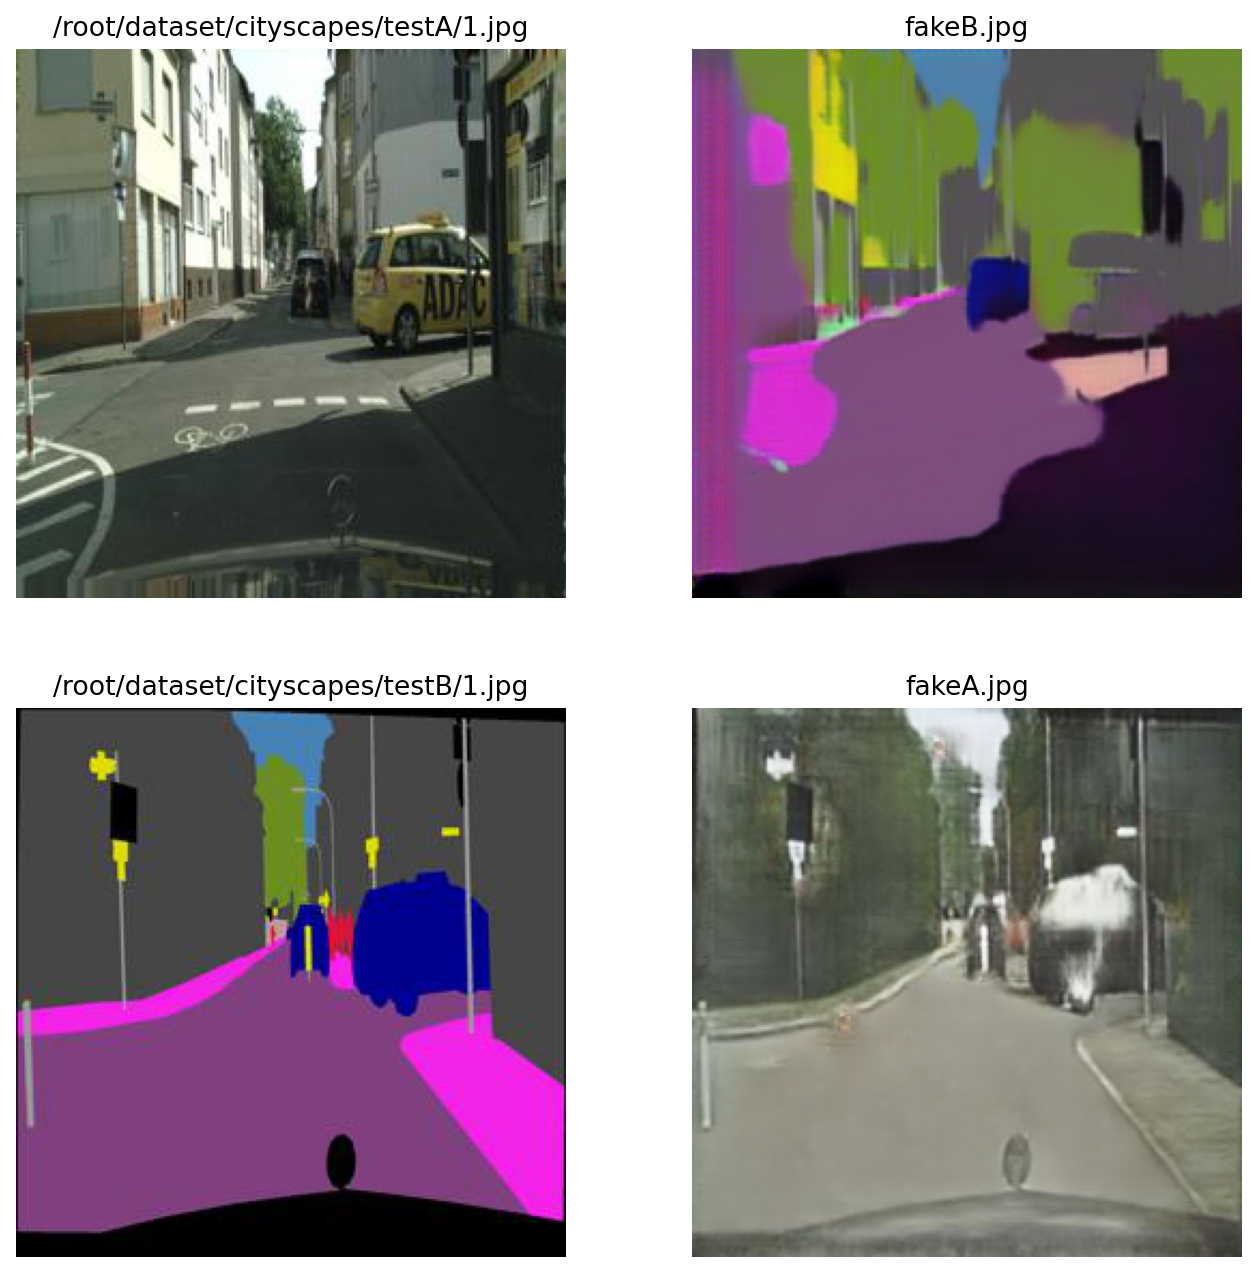

In [6]:
servable_name = 'cyclegan_cityscape'
dataset_name = 'cityscape'

if server_started() is True:
    # gray to color
    testA_path = '/root/dataset/cityscapes/testA/1.jpg'
    strategy = 'gray2color'
    fakeB_data = predict(testA_path, servable_name, dataset_name, strategy)

    # color to gray
    testB_path = '/root/dataset/cityscapes/testB/1.jpg'
    strategy = 'color2gray'
    fakeA_data = predict(testB_path, servable_name, dataset_name, strategy)

    # draw the plot
    plt.figure(dpi=160, figsize=(10, 10))

    plt.subplot(221)
    plt.imshow(Image.open(testA_path))
    plt.axis('off')
    plt.title(testA_path)

    plt.subplot(222)
    plt.imshow(Image.fromarray(np.uint8(fakeB_data)))
    plt.axis('off')
    plt.title("fakeB.jpg")

    plt.subplot(223)
    plt.imshow(Image.open(testB_path))
    plt.axis('off')
    plt.title(testB_path)

    plt.subplot(224)
    plt.imshow(Image.fromarray(np.uint8(fakeA_data)))
    plt.axis('off')
    plt.title("fakeA.jpg")

    plt.show()
else:
    print("Server not started")

## Check output

If user can see 4 pics, that means two on the left column are from original test datset, while two pic on the right column are the generated pic.

 ## Shutdown server
 
To restart and try another checkpoint file, click `Kernel` at the top, then `Restart & Clear Output`, replace the `servable_json` code and `predict()` function
 
Run the following code to shutdown Flask server:

In [7]:
shutdown()

'Server shutting down...'